### Adding a method to interpret RF classifier and be able to give feedback to user in webapp

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import set_config
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score , precision_score, recall_score, f1_score,\
            precision_recall_curve, confusion_matrix, plot_confusion_matrix

from treeinterpreter import treeinterpreter as ti

import pickle

In [22]:
#load the model from disk
filename = './RandomForestClassifier_NoCovidFeatures_Webapp_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, y_test)
#print(result)

In [23]:
#lets remember how we built the loaded model
loaded_model.named_steps

{'preproc': ColumnTransformer(transformers=[('string_preproc', TargetEncoder(),
                                  Index([], dtype='object')),
                                 ('numeric_preproc', StandardScaler(),
                                  Index(['SUBSTANCE_SCORE', 'PADS_TOTAL', 'IUS_total', 'PEMBERTON_TOTAL',
        'LONELI', 'DAI_TOTAL', 'BRS_total', 'OFS_total'],
       dtype='object'))]),
 'classifier': RandomForestClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=100,
                        n_estimators=200)}

In [24]:
loaded_model.steps[1][1]

RandomForestClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=100,
                       n_estimators=200)

In [25]:
loaded_model.feature_names_in_

array(['SUBSTANCE_SCORE', 'PADS_TOTAL', 'IUS_total', 'PEMBERTON_TOTAL',
       'LONELI', 'DAI_TOTAL', 'BRS_total', 'OFS_total'], dtype=object)

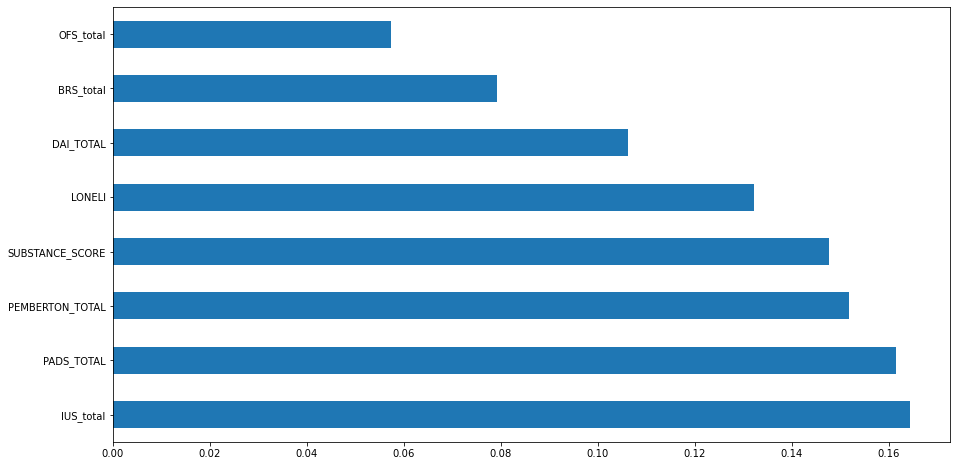

In [26]:
#checking feature importances
columns_importance = pd.Series(loaded_model.steps[1][1].feature_importances_, index=loaded_model.feature_names_in_)
fig = plt.figure(figsize = (15, 8))
columns_importance.nlargest(10).plot(kind = 'barh');

In [27]:
# we create a random observation within accepted features values
instance = pd.DataFrame(data = {'SUBSTANCE_SCORE': 0,
								'PADS_TOTAL': 17,
								'IUS_total': 12,
								'PEMBERTON_TOTAL': 5,
								'LONELI': 3,
								'DAI_TOTAL': 5,
								'BRS_total': 3,
								'OFS_total': 10
							}, dtype = np.float16, index = [0]
                        )
instance

,SUBSTANCE_SCORE,PADS_TOTAL,IUS_total,PEMBERTON_TOTAL,LONELI,DAI_TOTAL,BRS_total,OFS_total
0,0.0,17.0,12.0,5.0,3.0,5.0,3.0,10.0


In [28]:
#make prediction
prediction_class = loaded_model.predict(instance)
prediction_proba = loaded_model.predict_proba(instance)

#find feature contributions
prediction_ti, bias, contributions = ti.predict(loaded_model[-1], loaded_model[:-1].transform(instance))

In [29]:
#prepare results to plot and interpret them in a waterfall chart
if prediction_class == 1:
    fig_y = []
    for i, element in enumerate(contributions[0][:, 1:].tolist()):
        fig_y.append(contributions[0][:, 1:].tolist()[i][0])
    fig_y.append(bias[0][1] + sum(fig_y))
    fig_y.insert(0, bias[0][1])

    print('Class 0 prediction', prediction_ti[0][0])
    print('Class 1 prediction', prediction_ti[0][1])
    print('Class 0 bias (trainset prior)', bias[0][0])
    print('Class 1 bias (trainset prior)', bias[0][1])
    print('Feature contributions (with bias and total probability added):', fig_y)

    print('Eres resiliente, con un score de predicción igual a', round(prediction_proba[0, 1], 2))
else:
    fig_y = []
    for i, element in enumerate(contributions[0][:, 0:1].tolist()):
        fig_y.append(contributions[0][:, 0:1].tolist()[i][0])
    fig_y.append(bias[0][0] + sum(fig_y))
    fig_y.insert(0, bias[0][0])

    print('Class 0 prediction', prediction_ti[0][0])
    print('Class 1 prediction', prediction_ti[0][1])
    print('Class 0 bias (trainset prior)', bias[0][0])
    print('Class 1 bias (trainset prior)', bias[0][1])
    print('Feature contributions (with bias and total probability added):', fig_y)

    print('No eres resiliente, con un score de predicción igual a', round(prediction_proba[0, 0], 2))

fig = go.Figure(go.Waterfall(
    name = 'Feature contribution', orientation = 'v',
    measure = ['relative', 'relative', 'relative', 'relative', 'relative', 'relative', 'relative', 'relative', 'relative', 'total'],
    x = ['Bias', 'Consumo de sustancias', 'Paranoia', 'Incertidumbre', 'Felicidad', 'Soledad', 'Ansiedad por la muerte', 'Afrontamiento dificultades', 'Apertura al futuro', 'Probabilidad'],
    textposition = "outside",
    text = list(map(str, [round(num, 3) for num in fig_y])),
    y = fig_y,
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = 'Feature contribution',
        showlegend = False
)

config = {'displayModeBar': False}
fig.show(use_container_width = True, config = config)

Class 0 prediction 0.4420222379139119
Class 1 prediction 0.5579777620860887
Class 0 bias (trainset prior) 0.369971264367816
Class 1 bias (trainset prior) 0.6300287356321842
Feature contributions (with bias and total probability added): [0.6300287356321842, 0.04191055342060908, -0.09919351787831915, 0.05942541919578338, -0.0978973216699782, 0.03777719921068469, 0.035265374123176395, -0.012173713361660817, -0.037164966586391054, 0.5579777620860885]
Eres resiliente, con un score de predicción igual a 0.56


### Creating a Decision Tree model with selected features to add interpretation

In [30]:
#loading the dataset
dataset = pd.read_csv('./covid_dataset_sel.csv', index_col = 0, dtype = {'ID': str, 'RESILIENT_W1234': str})
dataset.head()

#preparing the target
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '00', 'target_cat'] = 'Resilient'
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '10', 'target_cat'] = 'Recovered'
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '11', 'target_cat'] = 'Sustained distress'
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '01', 'target_cat'] = 'Delayed distress'

dataset.dropna(inplace = True) # lets drop rows where at least one value is missing (will come just from this last column we created)

dataset['target_num'] = [1 if x in ['Resilient', 'Recovered'] else 0 for x in dataset['target_cat']]
dataset

,ID,Edad,Sexo,Zona_vivienda,Pertenencia_vecindario,Comodidad_vencindario_llaves,Comodidad_vencindario_compra,Titulación,Situación_laboral,Adultos_vivienda,...,DAI_TOTAL,IUS_total,PEMBERTON_TOTAL,PI_total,PGT_SF_total,JTC_COVID,JTC_GENERAL,RESILIENT_W1234,target_cat,target_num
323,1017726,42.0,Femenino,Urbana,Mucho,Muy incómodo,Algo cómodo,Master,Empleado tiempo completo,2,...,20.0,52.0,6.500000,1.666667,19.0,1.0,1.0,1199,Sustained distress,0
324,108162,46.0,Femenino,Urbana,Ligeramente,Algo incómodo,Algo incómodo,Licenciatura,Empleado medio tiempo,2,...,10.0,25.0,8.083333,4.166667,39.0,1.0,2.0,1199,Sustained distress,0
325,1111859,55.0,Masculino,Urbana,Ligeramente,Algo cómodo,Algo cómodo,Licenciatura,Empleado tiempo completo,2,...,11.0,21.0,7.666667,4.500000,36.0,8.5,7.5,0099,Resilient,1
326,1119736,59.0,Femenino,Urbana,Ligeramente,Algo cómodo,Algo cómodo,Master,Empleado medio tiempo,3,...,15.0,17.0,5.916667,3.333333,56.0,1.0,1.0,0099,Resilient,1
327,1151720,22.0,Femenino,Urbana,Moderadamente,Muy incómodo,Algo incómodo,Master,Estudiante,4,...,15.0,31.0,8.750000,3.333333,47.0,1.0,1.5,1099,Recovered,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,996007,45.0,Masculino,Urbana,Ligeramente,Algo incómodo,Algo incómodo,Grado universitario,Empleado tiempo completo,2,...,15.0,25.0,8.416667,2.333333,32.0,5.5,1.0,0000,Resilient,1
1947,997159,25.0,Masculino,Urbana,Moderadamente,Algo cómodo,Algo incómodo,Grado universitario,Empleado medio tiempo,2,...,5.0,32.0,6.833333,2.666667,33.0,3.0,3.5,0100,Delayed distress,0
1948,997683,67.0,Masculino,Rural,Mucho,Muy cómodo,Muy cómodo,Bachillerato,Jubilado,2,...,6.0,27.0,8.333333,3.666667,39.0,1.0,1.0,0000,Resilient,1
1949,997717,31.0,Masculino,Urbana,Ligeramente,Algo cómodo,Algo incómodo,Master,Empleado tiempo completo,2,...,15.0,47.0,5.416667,2.333333,32.0,5.5,2.0,0101,Delayed distress,0


In [56]:
#separating target and features and keeping most important features from previous step
target = dataset['target_num']
features = dataset[['SUBSTANCE_SCORE',
                     'PADS_TOTAL',
                     'IUS_total',
                     'PEMBERTON_TOTAL',
                     'LONELI',
                     'DAI_TOTAL',
                     'BRS_total',
                     'OFS_total']]

#defining classifier
#classifier = LogisticRegression(max_iter = 10000)
#classifier = DecisionTreeClassifier(min_samples_leaf = 40, min_samples_split = 100, max_depth = 4)
#classifier = RandomForestClassifier(n_estimators = 10000,
#                                    min_samples_leaf = 40,
#                                    min_samples_split = 110,
#                                    max_depth = 6,
#                                    max_features = 10)
dt = DecisionTreeClassifier(random_state = 0)

#parameters grid to hypertune
random_param_grid = {'min_samples_leaf': range(40, 90, 10),
                     'min_samples_split': range(90, 140, 10),
                     'max_depth': range(5, 10, 1)
                     }

#complete search of parameters, using 3 fold cross validation
dt_grid = GridSearchCV(estimator = dt,
                       param_grid = random_param_grid,
                       cv = 3,
                       scoring = 'accuracy'
)

#separating numeric and categorical features
features_string = features.select_dtypes('object').columns
features_numeric = features.select_dtypes('number').columns

#defining preprocessing for categorical and numerical features 
preproc = ColumnTransformer([('string_preproc', TargetEncoder(), features_string), 
                             ('numeric_preproc', StandardScaler(), features_numeric)])

#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 0)

#fit the random search model after applying preproc to features
dt_grid.fit(preproc.fit_transform(X_train, y_train), y_train)

dt_best = dt_grid.best_estimator_

#creating the modeling pipeline
pipeline = Pipeline([('preproc', preproc),
                     ('classifier', dt_best)])
pipeline

/Users/ignacio/Documents/covid/resilience-study/env/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning:

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

/Users/ignacio/Documents/covid/resilience-study/env/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning:

Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327



Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('string_preproc',
                                                  TargetEncoder(),
                                                  Index([], dtype='object')),
                                                 ('numeric_preproc',
                                                  StandardScaler(),
                                                  Index(['SUBSTANCE_SCORE', 'PADS_TOTAL', 'IUS_total', 'PEMBERTON_TOTAL',
       'LONELI', 'DAI_TOTAL', 'BRS_total', 'OFS_total'],
      dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=40,
                                        min_samples_split=90,
                                        random_state=0))])

last model accuracy_score_test 0.7266009852216748
last model accuracy_score_train 0.7577996715927751
last model precision_score_test 0.7802197802197802
last model precision_score_train 0.7969735182849937
last model recall_score_test 0.8068181818181818
last model recall_score_train 0.825065274151436
last model f1_score_test 0.7932960893854749
last model f1_score_train 0.8107761385503529
last model auc_score_test 0.692141485275288
last model auc_score_train 0.7344352919429749


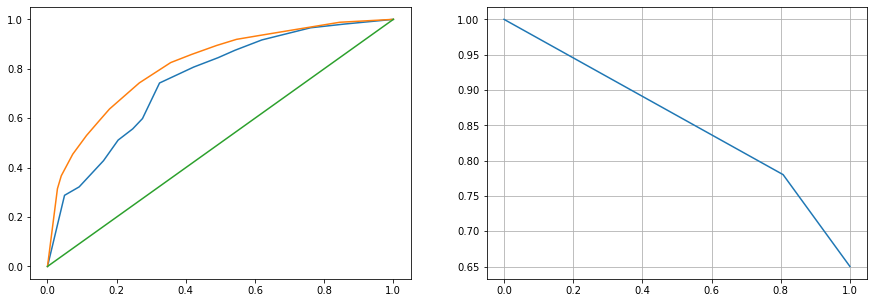

In [57]:
#trainning the model
pipeline.fit(X_train, y_train)

#making predictions
predictions_test = pipeline.predict(X_test)
predictions_proba_test = pipeline.predict_proba(X_test)
predictions_train = pipeline.predict(X_train)
predictions_proba_train = pipeline.predict_proba(X_train)

#evaluating the model
#metrics
accuracy_test = accuracy_score(y_test, predictions_test)
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)
f1_test = f1_score(y_test, predictions_test)
auc_test = roc_auc_score(y_test, predictions_test)

accuracy_train = accuracy_score(y_train, predictions_train)
precision_train = precision_score(y_train, predictions_train)
recall_train = recall_score(y_train, predictions_train)
f1_train = f1_score(y_train, predictions_train)
auc_train = roc_auc_score(y_train, predictions_train)

# print and graph last result
print('last model accuracy_score_test', accuracy_test)
print('last model accuracy_score_train', accuracy_train)
print('last model precision_score_test', precision_test)
print('last model precision_score_train', precision_train)
print('last model recall_score_test', recall_test)
print('last model recall_score_train', recall_train)
print('last model f1_score_test', f1_test)
print('last model f1_score_train', f1_train)
print('last model auc_score_test', auc_test)
print('last model auc_score_train', auc_train)

precision, recall, _ = precision_recall_curve(y_test, predictions_test)
roc_dt_test = roc_curve(y_test, predictions_proba_test[:,1])
roc_dt_train = roc_curve(y_train, predictions_proba_train[:,1])

#plotting results
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(roc_dt_test[0], roc_dt_test[1]);
ax[0].plot(roc_dt_train[0], roc_dt_train[1]);
ax[0].plot([0, 1], [0, 1]);

ax[1].plot(recall, precision)
ax[1].grid()

In [58]:
cv_results = pd.DataFrame(dt_random.cv_results_)
cv_results.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009364,0.001282,0.001175,0.000394,90,40,5,"{'min_samples_split': 90, 'min_samples_leaf': ...",0.684729,0.687192,0.729064,0.700328,0.020344,1
1,0.005564,0.000596,0.001007,0.000539,100,40,5,"{'min_samples_split': 100, 'min_samples_leaf':...",0.684729,0.687192,0.729064,0.700328,0.020344,1
26,0.004440,0.000265,0.000587,0.000172,100,40,6,"{'min_samples_split': 100, 'min_samples_leaf':...",0.684729,0.687192,0.729064,0.700328,0.020344,1
25,0.004380,0.000340,0.000421,0.000042,90,40,6,"{'min_samples_split': 90, 'min_samples_leaf': ...",0.684729,0.687192,0.729064,0.700328,0.020344,1
50,0.006731,0.000877,0.000953,0.000132,90,40,7,"{'min_samples_split': 90, 'min_samples_leaf': ...",0.684729,0.687192,0.729064,0.700328,0.020344,1
51,0.009072,0.001730,0.000849,0.000050,100,40,7,"{'min_samples_split': 100, 'min_samples_leaf':...",0.684729,0.687192,0.729064,0.700328,0.020344,1
76,0.004432,0.000187,0.000608,0.000191,100,40,8,"{'min_samples_split': 100, 'min_samples_leaf':...",0.684729,0.687192,0.729064,0.700328,0.020344,1
75,0.004693,0.000126,0.000579,0.000149,90,40,8,"{'min_samples_split': 90, 'min_samples_leaf': ...",0.684729,0.687192,0.729064,0.700328,0.020344,1
2,0.005557,0.000503,0.000610,0.000128,110,40,5,"{'min_samples_split': 110, 'min_samples_leaf':...",0.684729,0.672414,0.729064,0.695402,0.024328,9
52,0.007531,0.001541,0.002153,0.001661,110,40,7,"{'min_samples_split': 110, 'min_samples_leaf':...",0.684729,0.672414,0.729064,0.695402,0.024328,9


In [59]:
cm = confusion_matrix(y_test, predictions_test)
print(cm)

[[ 82  60]
 [ 51 213]]


In [60]:
pipeline.steps[1][1]

DecisionTreeClassifier(max_depth=5, min_samples_leaf=40, min_samples_split=90,
                       random_state=0)

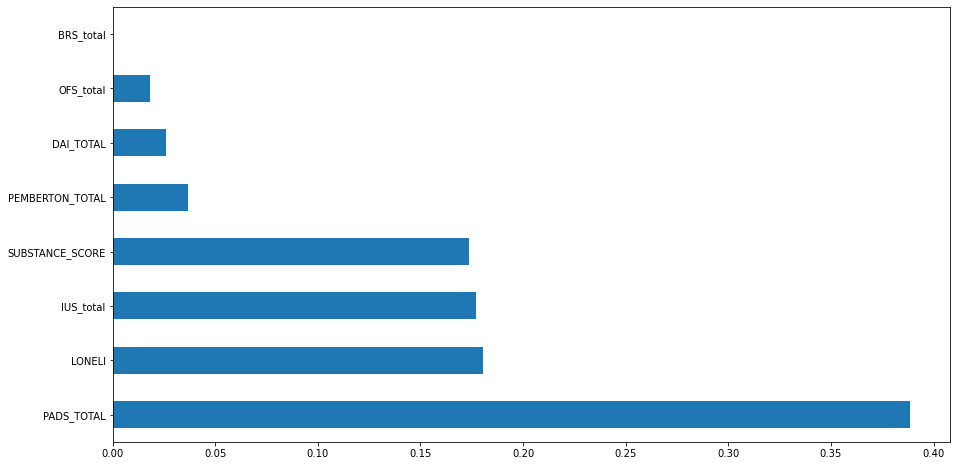

In [61]:
columns_importance = pd.Series(pipeline.steps[1][1].feature_importances_, index=features.columns)
fig = plt.figure(figsize = (15, 8))
columns_importance.nlargest(10).plot(kind = 'barh');

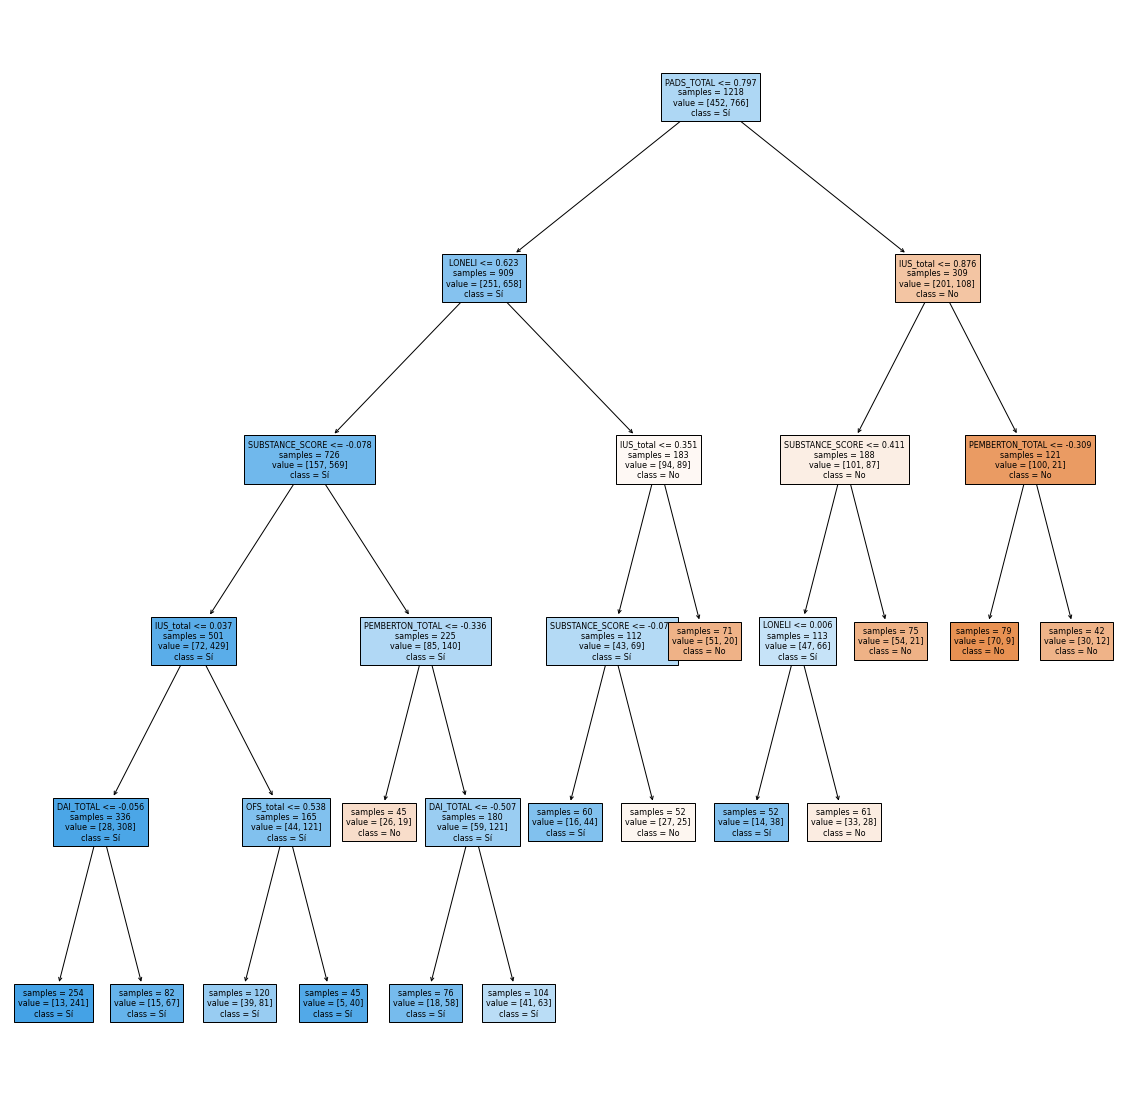

In [62]:
#snippet code for a decision tree model
plt.figure(figsize = (20,20))
plot_tree(pipeline.steps[1][1],
              feature_names = pipeline.feature_names_in_,
              class_names = ['No', 'Sí'],
              filled = True,
              impurity = False,
              fontsize = 8)
plt.show()